* An airline company is keen on understanding their customers better to enhance their overall satisfaction. In pursuit of this goal, the company has gathered comprehensive information about 20,000 of their customers. This dataset includes detailed responses from a satisfaction survey. By analyzing this data, we aim to uncover key insights into customer preferences, identify areas of improvement, and ultimately help the airline tailor its services to meet customer expectations more effectively.

* The satisfaction survey encompasses various aspects of the customer experience, from booking and boarding to in-flight services and baggage handling. Our analysis will focus on identifying trends, pinpointing common issues, and segmenting customers into distinct groups based on their feedback. This will enable the airline to implement targeted strategies to enhance customer satisfaction and loyalty.

# Imports library

In [8]:
# import 
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns 
# MACHINE LEARNING 
from sklearn.preprocessing import Binarizer,OneHotEncoder,OrdinalEncoder,StandardScaler,StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.compose import ColumnTransformer 
from  sklearn import set_config 
set_config(transform_output='pandas')
pd.set_option('display.max_columns',100)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score , recall_score , f1_score  , confusion_matrix , ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score , classification_report , roc_auc_score, RocCurveDisplay
# Feature Engineering    
from sklearn.decomposition import PCA 
from collinearity import SelectNonCollinear
from sklearn.feature_selection import f_classif
# Deep learning 
from tensorflow.keras import Sequential 
from tensorflow.keras import metrics 
from tensorflow.keras.layers import Dense , Dropout 
from tensorflow.keras.callbacks import EarlyStopping 


# EDA Functions

In [9]:
def plot_numeric_vs_target(df, x, y, figsize=(6,4),
                           target_type='reg', estimator='mean',
                           errorbar='ci',sorted=False,ascending=False,
                           **kwargs): # kwargs for sns.regplot

  nulls = df[[x,y]].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,y,])
  else:
    temp_df = df
  # Create the figure
  fig, ax = plt.subplots(figsize=figsize)

  # REGRESSION-TARGET PLOT
  if 'reg' in target_type:
    # Calculate the correlation
    corr = df[[x,y]].corr().round(2)
    r = corr.loc[x,y]
    # Plot the data
    scatter_kws={'ec':'white','lw':1,'alpha':0.8}
    sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
    ## Add the title with the correlation
    ax.set_title(f"{x} vs. {y} (r = {r})")

  # CLASSIFICATION-TARGET PLOT
  elif 'class' in target_type:

    # Sort the groups by median/mean
    if sorted == True:

      if estimator == 'median':
        group_vals = temp_df.groupby(y)[x].median()
      elif estimator =='mean':
        group_vals = temp_df.groupby(y)[x].mean()

      ## Sort values
      group_vals = group_vals.sort_values(ascending=ascending)
      order = group_vals.index

    else:
      # Set order to None if not calcualted
      order = None


    # Left Subplot (barplot)
    sns.barplot(data=temp_df, x=y, y=x, order=order,  estimator=estimator,
                errorbar=errorbar, ax=ax, **kwargs)

    # Add title
    ax.set_title(f"{x} vs. {y}")

    # rotate xaxis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


  # Final Adjustments & return
  fig.tight_layout()
  fig.show()
  return fig, ax


def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg',weights=None):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill',weights=weights)
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax


In [10]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict


def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    # Get predictions for training data
    y_train_pred = model.predict(X_train)
    # Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = model.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
    if output_dict == True:
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict



In [11]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes


In [12]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', values_format="d", colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, values_format=".2f", colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

# LODE & Clean DATA  

In [13]:
df = pd.read_csv('flight_df - flight_df.csv')
# null value  & duplicated  
print(f'Number of duplicated  :  {df.duplicated().sum()} ')
print (f'null value :  {df.isna().sum().sum()}')

df.info()

Number of duplicated  :  0 
null value :  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                20000 non-null  int64
 1   Class                              20000 non-null  int64
 2   Flight Distance                    20000 non-null  int64
 3   Inflight wifi service              20000 non-null  int64
 4   Departure/Arrival time convenient  20000 non-null  int64
 5   Ease of Online booking             20000 non-null  int64
 6   Gate location                      20000 non-null  int64
 7   Food and drink                     20000 non-null  int64
 8   Online boarding                    20000 non-null  int64
 9   Seat comfort                       20000 non-null  int64
 10  Inflight entertainment             20000 non-null  int64
 11  On-board service                   2

In [14]:
df.describe()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Loyal Customer,Business Travel,satisfied
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,39.477250,2.027800,1188.548000,2.727950,3.056100,2.751100,2.971350,3.202100,3.255300,3.439100,3.349100,3.385350,3.350850,3.623650,3.302850,3.635550,3.282650,14.318350,14.698250,0.490650,0.817850,0.687900,0.43305
std,15.108901,0.963054,1001.136957,1.326886,1.531134,1.396799,1.279575,1.332383,1.348485,1.323434,1.333348,1.278451,1.316602,1.186837,1.259131,1.184017,1.311734,36.451829,36.899857,0.499925,0.385978,0.463362,0.49551
min,7.000000,1.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,27.000000,1.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000
50%,40.000000,2.000000,842.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000
75%,51.000000,3.000000,1733.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,1.000000,1.000000,1.000000,1.00000
max,85.000000,3.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1305.000000,1280.000000,1.000000,1.000000,1.000000,1.00000


In [15]:
df['satisfied'].value_counts()

0    11339
1     8661
Name: satisfied, dtype: int64

# Explore data

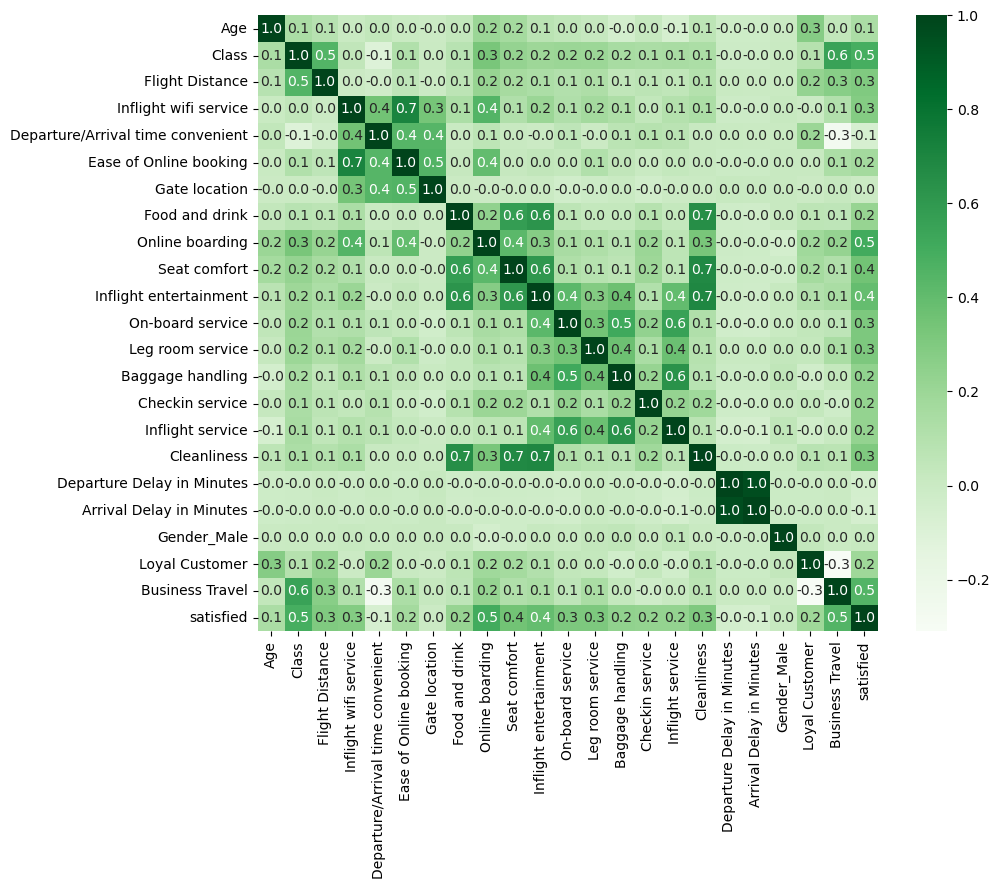

In [16]:
corr  =  df.corr()
# heatmap 
fig, ax =  plt.subplots(figsize=(10,8))
ax=sns.heatmap(corr,annot=True,fmt='.1f', cbar="k", cmap="Greens")

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Class vs. satisfied'}, xlabel='Class', ylabel='Percent'>)

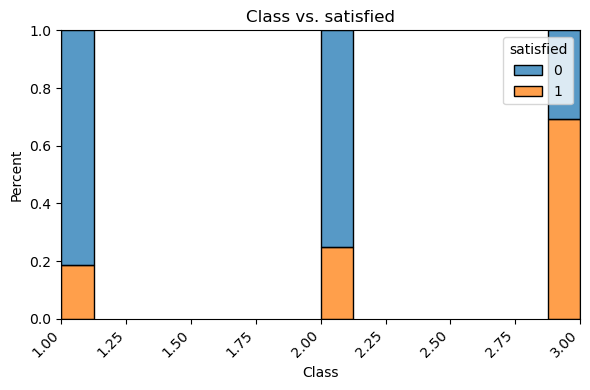

In [17]:
# plot calss satisfied
plot_categorical_vs_target(df,y='satisfied', x='Class' ,target_type='class')

* The analysis shows that Class 3 passenger category has the highest level of satisfaction at 70%, indicating that the services provided meet customer expectations well.
* On the other hand, Class 1 and Class 2 passenger categories show lower satisfaction rates of 20% and 30%, respectively, which indicates that there is a need to improve their services and increase their level of satisfaction.

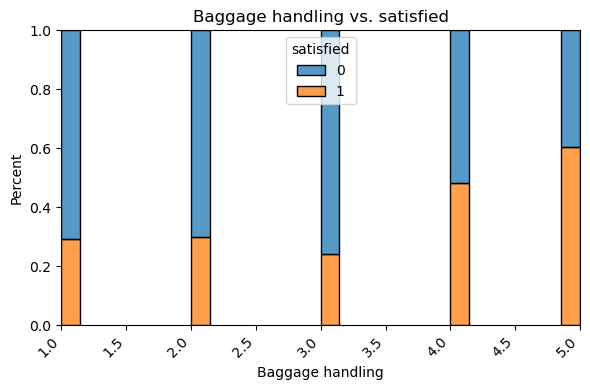

In [18]:
plot_categorical_vs_target(df, x= 'Baggage handling' ,y='satisfied',target_type='class'  )
plt.savefig("Baggang ")

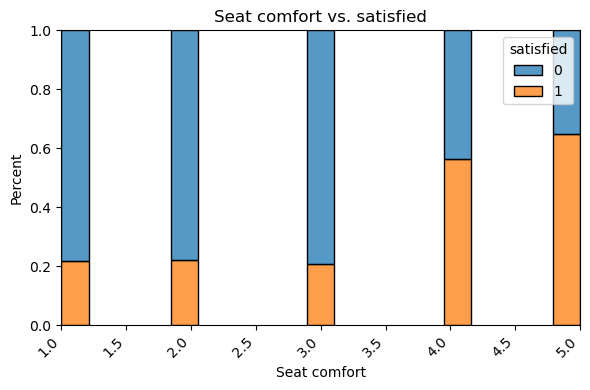

In [30]:
plot_categorical_vs_target(df, x= 'Seat comfort' ,y='satisfied',target_type='class')
plt.savefig("seat ")

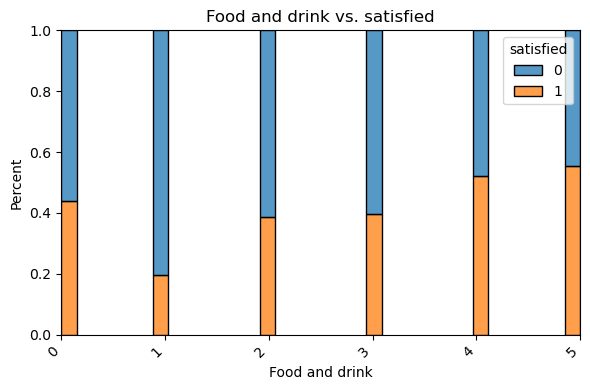

In [31]:
plot_categorical_vs_target(df, x='Food and drink' ,y='satisfied',target_type='class' )
plt.savefig("Food ")

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Leg room service vs. satisfied'}, xlabel='Leg room service', ylabel='Percent'>)

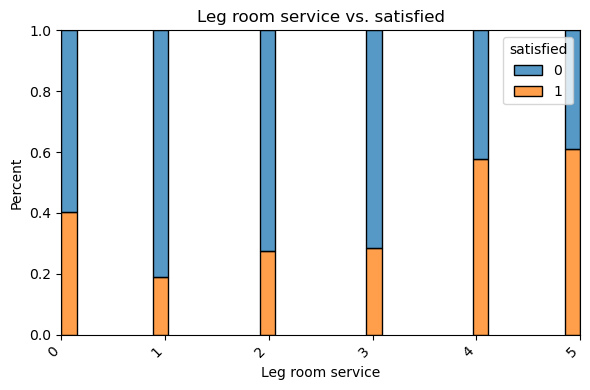

In [21]:
plot_categorical_vs_target(df, x='Leg room service' ,y='satisfied',target_type='class' )

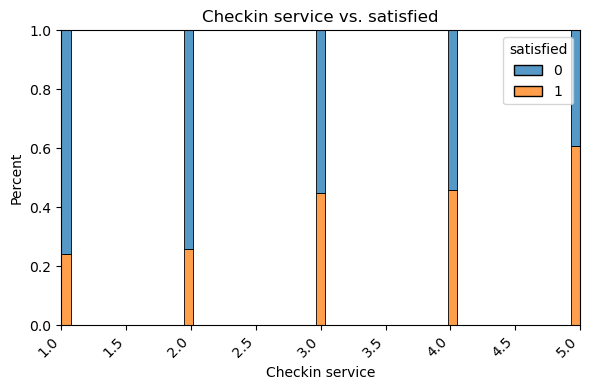

In [33]:
plot_categorical_vs_target(df, x='Checkin service' ,y='satisfied',target_type='class' )
plt.savefig("checkin ")

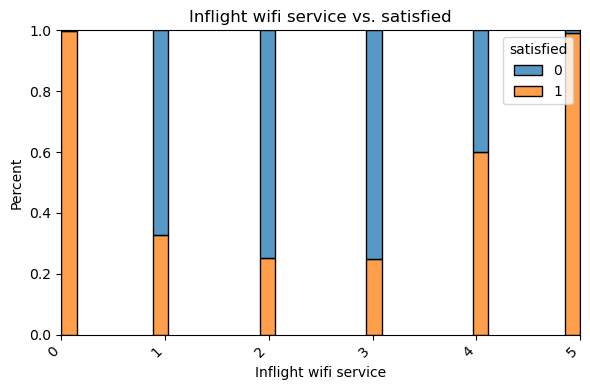

In [35]:
plot_categorical_vs_target(df, x='Inflight wifi service' ,y='satisfied',target_type='class' )
plt.savefig("Inflight wifi service")

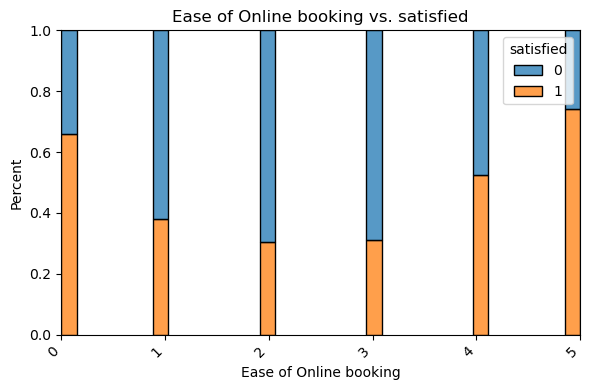

In [36]:
plot_categorical_vs_target(df, x='Ease of Online booking' ,y='satisfied',target_type='class' )
plt.savefig("Ease of Online booking")

C:\Users\Ashraf\AppData\Local\Temp\ipykernel_19280\1939109171.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Departure Delay in Minutes vs. satisfied'}, xlabel='satisfied', ylabel='Departure Delay in Minutes'>)

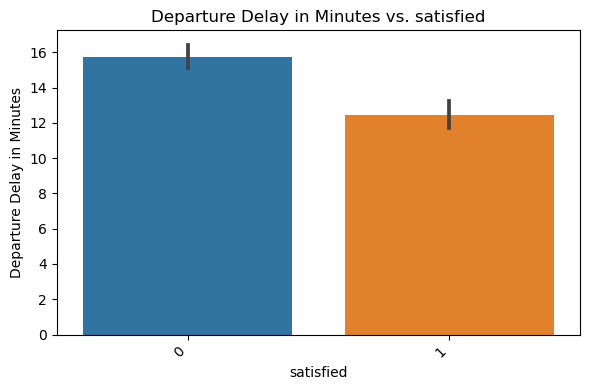

In [23]:
plot_numeric_vs_target(df,x='Departure Delay in Minutes', y ='satisfied' , target_type='class')

C:\Users\Ashraf\AppData\Local\Temp\ipykernel_19280\1939109171.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Arrival Delay in Minutes vs. satisfied'}, xlabel='satisfied', ylabel='Arrival Delay in Minutes'>)

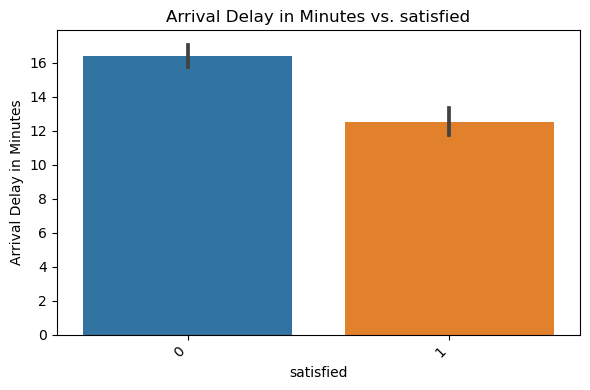

In [24]:
plot_numeric_vs_target(df,x='Arrival Delay in Minutes', y ='satisfied' ,target_type='class')

# Clustering:

In [25]:
# scaler  
scaler =  StandardScaler()
df_scaler= scaler.fit_transform(df)

## Kmeans 

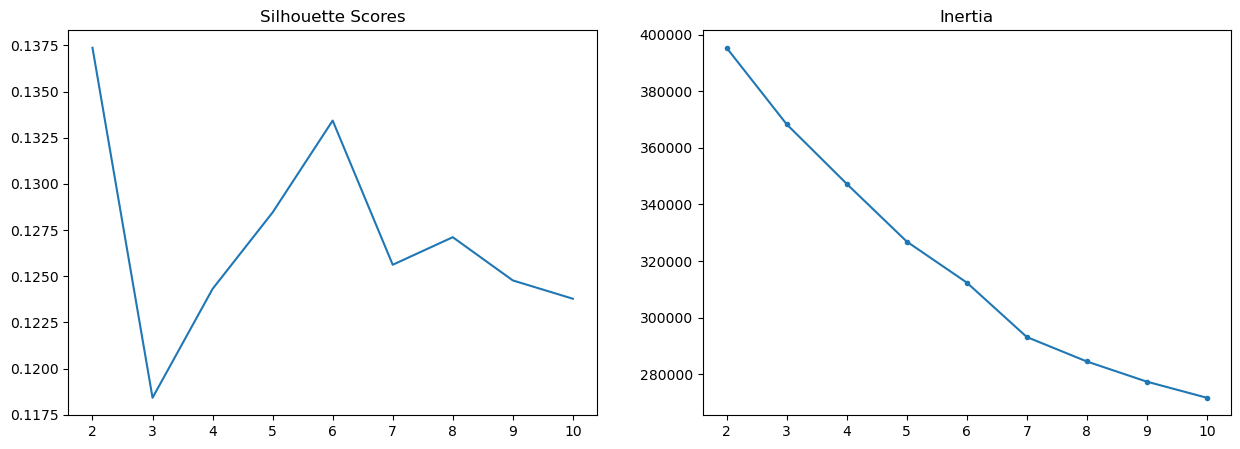

In [26]:
# Iterate over a range of k clusters to find the optimal number of clusters
ks = range (2,11)

sils = []
inertias = []
for k in ks:
  kmeans = KMeans(n_clusters=k, n_init = 'auto', random_state=42)
  kmeans.fit(df_scaler)
  sils.append(silhouette_score(df_scaler, kmeans.labels_))
  inertias.append(kmeans.inertia_)
#plot inertias and silhouette scores for each number of clusters.
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(ks, sils)
axes[0].set_title('Silhouette Scores')
axes[0].set_xticks(ks)
axes[1].plot(ks, inertias ,marker = '.')
axes[1].set_title('Inertia')
axes[1].set_xticks(ks);

In [37]:
# kmeans 
kmeans_model = KMeans(n_clusters=5,max_iter=100 , verbose=1,random_state=42) 
kmeans_model.fit(df_scaler)
df['cluster']=kmeans_model.labels_

C:\Users\Ashraf\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 480366.45296777843.
Iteration 1, inertia 348750.41312389506.
Iteration 2, inertia 339699.3786447021.
Iteration 3, inertia 335958.6871691167.
Iteration 4, inertia 333405.1843843914.
Iteration 5, inertia 331493.21120211855.
Iteration 6, inertia 329810.1421948138.
Iteration 7, inertia 328554.6306868807.
Iteration 8, inertia 327675.47578565136.
Iteration 9, inertia 327201.9550841021.
Iteration 10, inertia 327021.03029262903.
Iteration 11, inertia 326946.0932088632.
Iteration 12, inertia 326918.4623941795.
Iteration 13, inertia 326910.9368491748.
Iteration 14, inertia 326907.21347609453.
Iteration 15, inertia 326905.95329266327.
Converged at iteration 15: center shift 6.530870678682798e-05 within tolerance 0.00010000000000000433.
Initialization complete
Iteration 0, inertia 565790.5192839032.
Iteration 1, inertia 345381.4928841354.
Iteration 2, inertia 336465.476228986.
Iteration 3, inertia 332874.83808749553.
Iteration 4, inertia 331132.68554497

In [38]:
# Group the dataframe by cluster and aggregate by mean values
cluster_groups=df.groupby('cluster',as_index=False).mean()
cluster_groups

,cluster,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Loyal Customer,Business Travel,satisfied
0,0,36.994795,1.747857,966.953460,2.332823,2.853491,2.621249,2.934323,2.099663,2.554348,2.250459,1.946111,2.760563,2.905389,3.129669,2.874770,3.153399,2.029088,10.262400,10.942743,0.492958,0.731017,0.658298,0.108236
1,1,43.966631,2.867585,1876.529396,2.008210,1.811176,1.890360,1.918697,3.604343,4.112553,4.206303,4.207892,4.086070,4.067532,4.106992,3.729608,4.129767,3.879237,8.532044,8.739142,0.495233,0.967161,0.997881,0.951271
2,2,37.695788,1.295289,737.808674,2.410251,3.412741,2.314173,2.901847,3.993982,2.725462,3.949367,3.975721,3.349035,2.995850,3.622121,3.329736,3.682507,4.035900,9.739158,9.923221,0.460884,0.780245,0.266653,0.056028
3,3,41.430549,2.548803,1429.351478,4.328484,4.055373,4.204833,4.018067,3.661896,4.170577,4.020178,4.052323,3.792586,3.782496,3.956593,3.564524,3.933130,3.824261,8.492023,8.419521,0.515720,0.864618,0.933599,0.910605
4,4,38.697218,1.973813,1181.094926,2.741408,3.132570,2.764321,3.119476,3.049100,3.245499,3.327332,3.193126,3.180033,3.472995,3.607201,3.204583,3.289689,3.278232,170.196399,173.132570,0.497545,0.793781,0.697218,0.345336


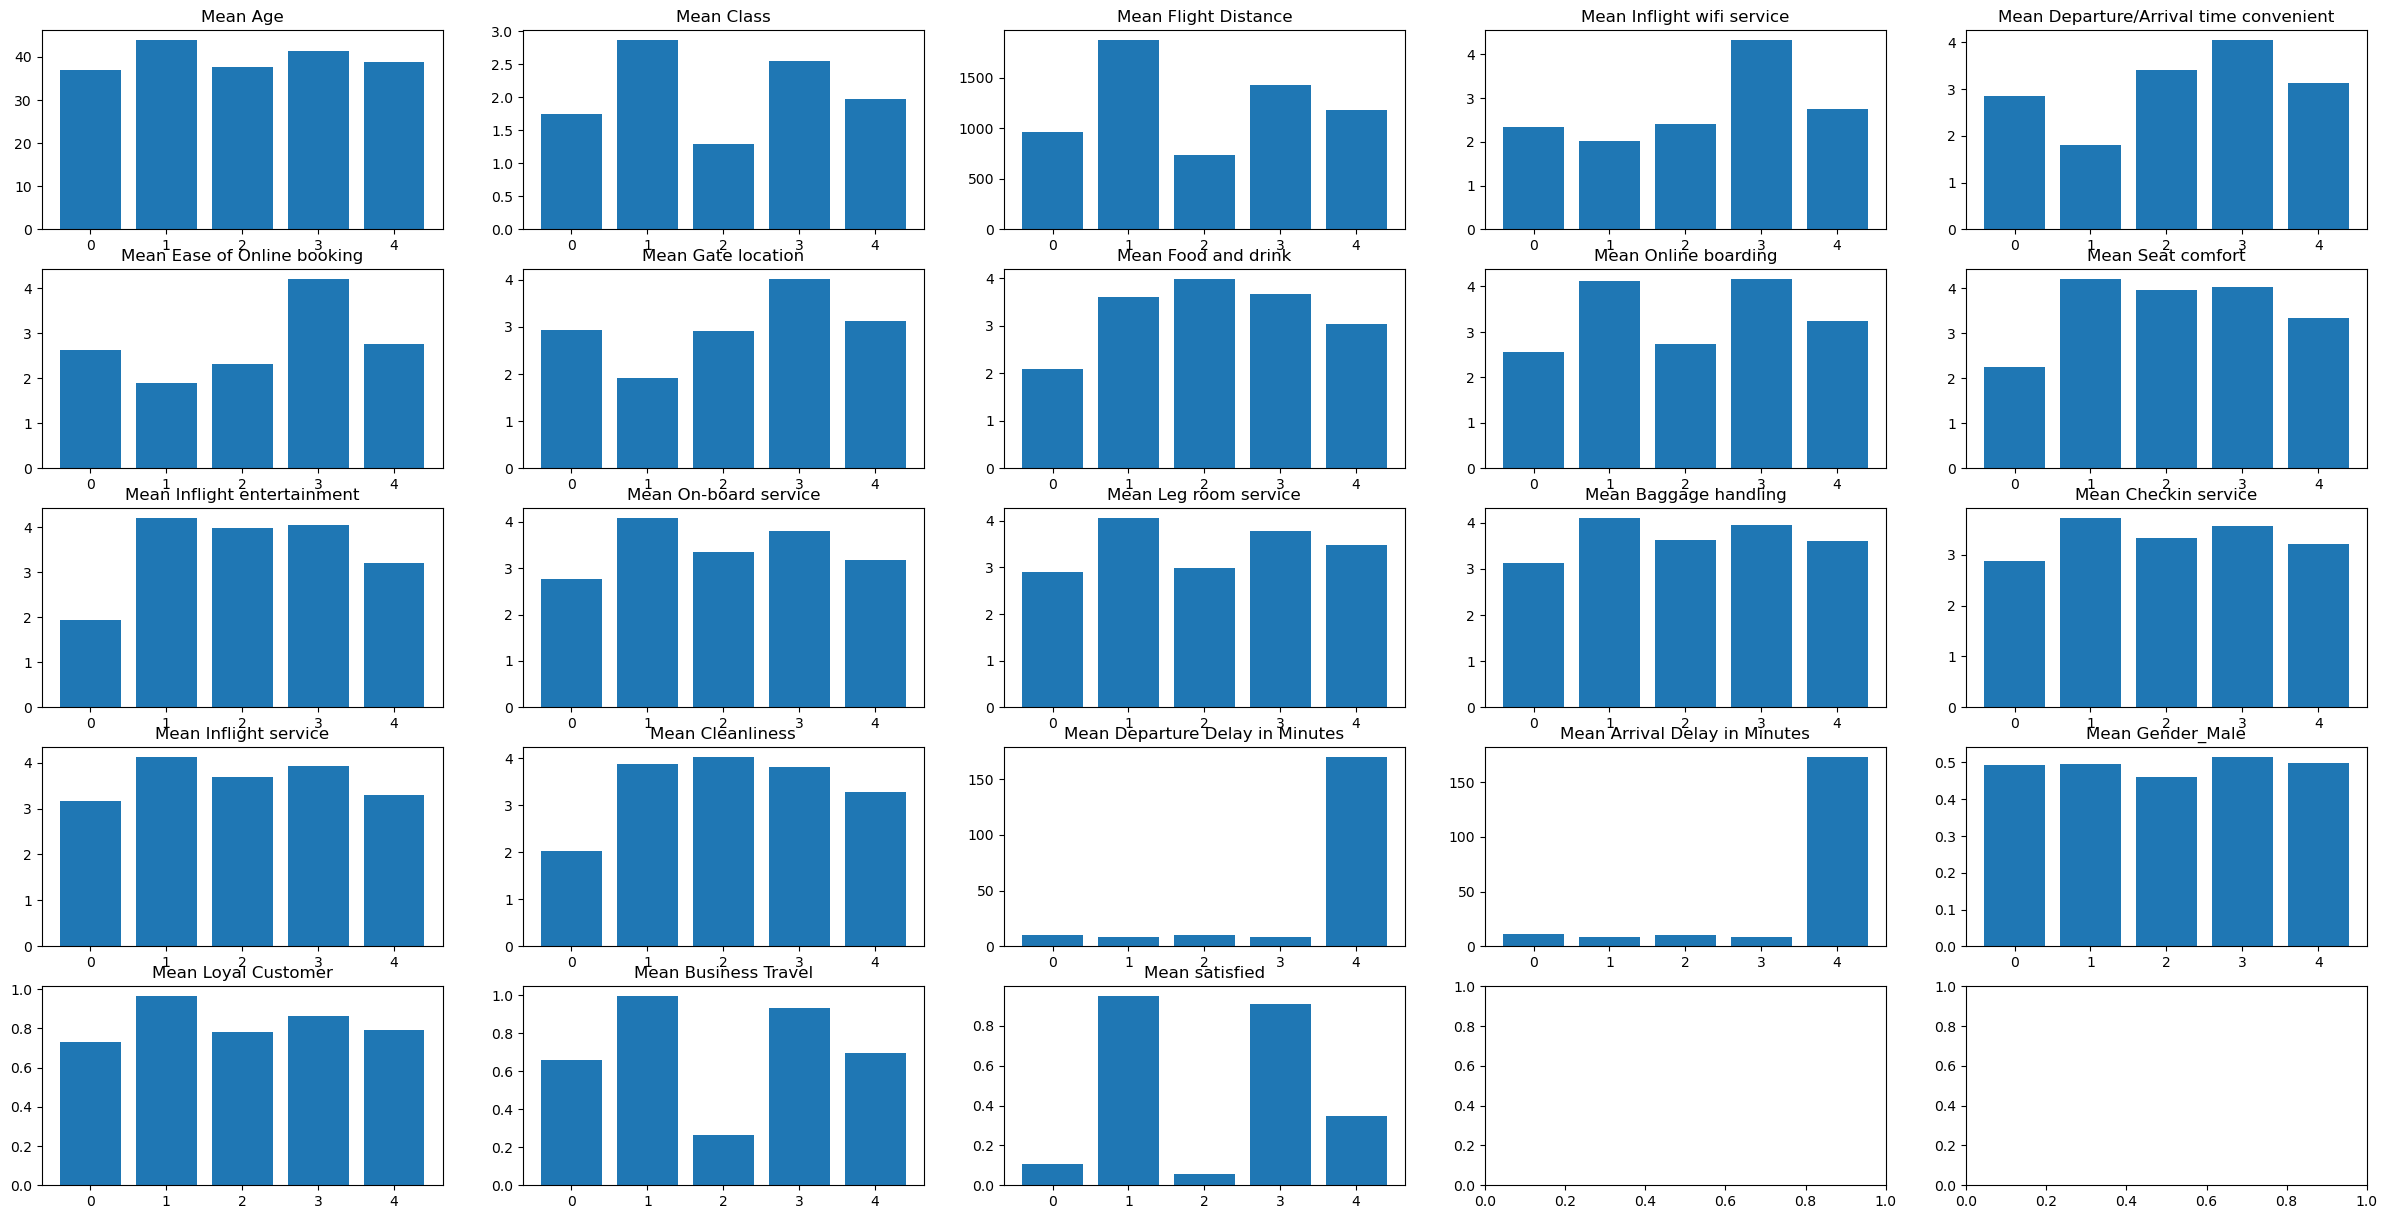

In [41]:
# Visualize means 
fig, axes = plt.subplots(5,5, figsize = (30, 15))
# fig is an array of dimensions 3,4.  axes.ravel() will flatten it to 12,1
axes = axes.ravel()
# Loop over columns and plot each in a separate figure, skip 'cluster' column
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')

plt.savefig('cluster')

### Cluster 0 : 

* The first category experience is characterized by moderate customer satisfaction, as strengths and weaknesses appear in their evaluations. Customers seem to be satisfied with the quality of the Wi-Fi service and the ease of the online booking process, but improvement is needed in food and beverage services, quality of seats, entertainment services and cleanliness.

* Improving the quality of food and beverage services to meet passenger expectations.
* Improving seat quality and providing a comfortable experience for passengers.
* Developing entertainment services on the plane to increase passenger satisfaction.
* Enhancing the quality of hygiene in the cabin to ensure a clean and healthy environment.
* Simplifying the online booking process and making it easier and smoother.
* Targeting passengers who travel for business with special offers and discounts to increase loyalty and attract more customers.

### Cluster 1  : The category distinguished by loyalty

* The experience of the second category shows some dissatisfaction due to several aspects of the passenger experience. It seems that the Wi-Fi services, ease of online booking process and the in-flight gate location do not meet passengers’ expectations as they should. However, passengers in this category are characterized by high loyalty and satisfaction, suggesting that they may be frequent travelers or enjoy the travel experience in general.

* Improving the quality of Wi-Fi services on the plane to meet passengers’ expectations and increase satisfaction.
* Simplify and improve the online booking process to provide a convenient and seamless experience for passengers.
* Reviewing the gate location on the plane and working to improve it to improve the passenger experience.
* Leverage higher passenger satisfaction and increase loyalty efforts to retain these customers and encourage them to travel more with the company.

### Cluster 2  : 

* The third category experience shows an overall low level of satisfaction, characterized by low ratings on Wi-Fi services, difficulty in the online reservation process, online check-in, and room services. It is also clear that passengers of this category are dissatisfied with their experience of traveling for work, which indicates that there are deep problems in providing services to this category.

* The quality of in-flight Wi-Fi services must be improved and a stable and fast connection provided to meet passengers' expectations.
* The online booking process should be simplified and a user-friendly interface should be provided to increase passenger convenience.
* The online check-in experience needs to be improved and made more convenient to improve passenger satisfaction.
* Room services must be reviewed and improved to ensure that passengers' needs and expectations are met in this aspect.
* The causes of dissatisfaction with the business travel experience must be studied and necessary measures taken to improve them and increase passenger satisfaction in this aspect.

### Cluster 3  : 

* It has high ratings in most aspects of the passenger experience. Passengers in this category are shown to be highly satisfied with Wi-Fi services, ease of online booking process, online check-in experience and room services. However, it cannot be ruled out that there are some points that may need improvement or development to achieve a better level of services.


* Recommendations:

  - We must continue to provide high-quality services that achieve passenger satisfaction and enhance their experience.
  - All aspects that receive high ratings should be reviewed to ensure that the highest levels of quality continue to be achieved.
  - Minor improvements or additional modifications may be considered to improve passenger experience and increase passenger satisfaction.
  - High ratings should be used as an opportunity to enhance the company's image, attract more customers and retain existing ones.

### Cluster 4   : 

 * Class 5 ratings show varying levels of satisfaction between aspects of the passenger experience. Although there are good ratings for the quality of cleanliness, there are some points that need improvement, such as the quality of the online booking process, the location of the gate in the plane, and the comfort of the seats. However, there appears to be high dissatisfaction due to delays in take-off and arrival, indicating the need to improve scheduling and operational services.

* The company must take the necessary measures to reduce delay rates in take-off and arrival and increase accuracy and reliability in scheduling and operation.
* A high level of cleanliness quality must continue to be maintained to ensure a comfortable passenger experience.

### Passenger Experience Evaluation Report for XYZ Airlines

- Introduction:
* This report aims to provide a comprehensive overview of passengers' experience aboard XYZ Airlines, based on evaluations and feedback across five different categories.

* Category 1 - Dissatisfied:

     * Good ratings for Wi-Fi service and ease of online booking.
     *  Complaints about seat comfort and negative ratings for in-flight entertainment services.
     *  Low satisfaction due to business travel.
* Category 2 - Comfort and Satisfaction:

   * High ratings for food and beverage quality and in-flight services.
   * Loyalty and business travel garner high ratings.
   * Overall high satisfaction among passengers.
* Category 3 - Challenges and Improvements:

   - Low ratings for Wi-Fi service and online booking ease.
   - Complaints about online check-in and room services.
   - Low satisfaction due to significant delays in departure and arrival.
* Category 4 - High Satisfaction:

   - High ratings across all aspects.
   - High passenger satisfaction.
* Category 5 - Continuous Improvement:

  - Mixed ratings, with complaints about departure and arrival delays.
  - High ratings for cleanliness.
* Recommendations:

   - Improve the quality of online booking and enhance its ease of use.
   - Provide a comfortable in-flight experience by improving seat comfort and entertainment services.
   - Minimize departure and arrival delays to increase passenger satisfaction and improve scheduling and operations accuracy.
   - Maintain high cleanliness standards.
   - Promptly address passenger complaints to enhance service quality.
* Conclusion:
By analyzing passenger evaluations and the provided recommendations, we can enhance the passenger experience and achieve the highest levels of satisfaction and service quality. We remain committed to continuous improvement to deliver an exceptional travel experience to all our customers.

# Modeling:

In [ ]:
# split data  
y= df['satisfied']
X= df.drop(columns= [ 'satisfied' ,'cluster'])
SEED = 42 
X_train , X_test , y_train, y_test = train_test_split(X,y , random_state=SEED , test_size=0.25)

# scaler data  
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)


## Feature Engineering  

In [ ]:
#  Instantiate the selector, indicate theshold for r, also include the appropriate scoring metric for the task
selector =SelectNonCollinear(correlation_threshold=0.7 , scoring= f_classif) 
selector.fit(X_train_scaler.values ,y_train.values) 
non_collinear=selector.get_support()
non_collinear[:20]

In [ ]:
# Filter training data
training_data_to_keep = X_train_scaler.values[:, non_collinear]
# Filter column names
columns = np.array(X_train_scaler.columns)[non_collinear]
# Make traing data into a dataframe
X_train_no_corr = pd.DataFrame(training_data_to_keep, columns = columns)

# Filter testing data
test_data_to_keep = X_test_scaler.values[:, non_collinear]
# Make test data into a dataframe
X_test_no_corr = pd.DataFrame(test_data_to_keep, columns = columns)
X_train_no_corr

## PCA  

In [ ]:
# RandomForestClassifier 
rf_cls =RandomForestClassifier(random_state=SEED) 
rf_cls.fit(X_train_no_corr , y_train)
# evaluate model  
evaluate_classification(rf_cls , X_train_no_corr , y_train , X_test_no_corr,y_test)

In [ ]:
# LogisticRegression model  
LogRegression = LogisticRegression(random_state=SEED)
LogRegression.fit(X_train_no_corr, y_train)
 
# evaluate model  
evaluate_classification(LogRegression , X_train_no_corr , y_train , X_test_no_corr,y_test)

##  * Choosing the Number of Components to Return

In [ ]:
# Initialize and fit PCA
pca = PCA()
pca.fit(X_train_scaler,y_train)


In [ ]:
explained =pd.Series(pca.explained_variance_ratio_,name='Explained Variance Ratio')
explained[:5]

In [ ]:
# plot the cumulative sum of the percentage of explained variance for each component and those before it.
ax = explained.cumsum().plot(marker='.')
# add a line to mark .95 (or 90%) variance explained
ax.axhline(.95, color='k');



In [ ]:
# Define PCA to address 95% of the variance
pca_95 =  PCA(n_components=0.90)
# fit and transform on training data
X_train_pca = pca_95.fit_transform(X_train_no_corr)
# transform on training data
X_test_pca = pca_95.transform(X_test_no_corr)
# obtain the number of PCs used
pca_95.n_components_

In [ ]:
# LogisticRegression model  
LogRegression_pca = LogisticRegression(random_state=SEED)
LogRegression_pca.fit(X_train_pca, y_train)
# evaluate model  
evaluate_classification(LogRegression_pca, X_train_pca , y_train , X_test_pca,y_test)

# Deep learning 

In [ ]:
# shape 
input_shape =X_train_scaler.shape[1]
input_shape

## Model 1 

In [ ]:
# Build binary classification model within function
def build_model():
    # Instantiate Model 
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(22, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dense(16, 
                activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation = 'sigmoid'))
    
    # Compile Model
    model.compile(loss = 'bce', optimizer = 'adam',
             metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model



In [ ]:
# Call our build function to build model
clf_model = build_model()

# Get model summary
clf_model.summary()



In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = clf_model.fit(X_train_scaler, y_train,
                        validation_split=.2,
                        epochs=100,
                        verbose=0, callbacks = [early_stop])



In [ ]:
plot_history(history)

In [ ]:
y_pard = clf_model.predict(X_test_scaler)
y_pard= np.round(y_pard)
y_pard[:5]

In [ ]:
classification_metrics(y_test , y_pard)

## Model 2 

In [ ]:

from keras.regularizers import l1_l2 ,l1,l2
# Build binary classification model within function
def build_model():
    # Instantiate Model 
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(22, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu' , kernel_regularizer=l2(0.01))) # What activation function are you using?
    model.add(Dense(16, 
                activation = 'relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(Dropout(.2))
    model.add(Dense(1, activation = 'sigmoid'))
    
    # Compile Model
    model.compile(loss = 'bce', optimizer = 'adam',
             metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model


In [ ]:
cls_model2 = build_model()
cls_model2.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = cls_model2.fit(x= X_train_scaler , y = y_train , epochs=100 , verbose= 1 ,callbacks=[early_stop], validation_split=0.25 )
plot_history(history)

In [ ]:
y_predict = cls_model2.predict(X_test_scaler)
y_predict = np.round(y_predict)
classification_metrics(y_test , y_predict)

##  Model 3

In [ ]:

from keras.regularizers import l1_l2 ,l1,l2
# Build binary classification model within function
def build_model():
    # Instantiate Model 
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(16, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu' , kernel_regularizer=l2(0.01))) # What activation function are you using?
    model.add(Dense(8, 
                activation = 'relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(Dropout(.2))
    model.add(Dense(1, activation = 'sigmoid'))
    
    # Compile Model
    model.compile(loss = 'bce', optimizer = 'adam',
             metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model

In [ ]:
cls_model3 = build_model()
cls_model3.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = cls_model3.fit(x= X_train_scaler , y = y_train , epochs=80 , verbose = 1 ,callbacks=[early_stop], validation_split=0.25 )
plot_history(history)

In [ ]:
y_predict = cls_model3.predict(X_test_scaler)
y_predict = np.round(y_predict)
classification_metrics(y_test , y_predict)

# Model Selection Report for Predicting Customer Satisfaction
 
An airline company is keen on understanding their customers better to enhance their overall satisfaction. As part of this project, we developed three different models to predict customer satisfaction based on the data from a satisfaction survey of 20,000 customers. This report evaluates the performance of these models and selects the best one for predicting customer satisfaction.

* Models Evaluated
  - Logistic Regression Model
  - Deep Learning Model (Keras)
* Model Evaluation Metrics
* The models were evaluated using the following metrics:

* Precision: The ratio of true positive predictions to the total number of positive predictions made by the model.
* Recall: The ratio of true positive predictions to the total number of actual positive cases in the data.
* F1 Score: The harmonic mean of precision and recall.
* Accuracy: The percentage of correct predictions made by the model out of all predictions.
## Logistic Regression Model Performance
* The classification metrics for the logistic regression model on the test data are as follows:

* Metric	 Class 0 (Not Satisfied)	  Class 1 (Satisfied)	Macro Average	Weighted Average
   - Precision	      0.87	                       0.86	             0.87 	           0.87
   - Recall	          0.90	                       0.83	             0.86	           0.87
   - F1-Score	      0.89	                       0.84	             0.87	           0.87
   - Accuracy	-	-	-	0.87
## Deep Learning Model (Keras) Performance
* The classification metrics for the deep learning model on the test data are as follows:

* Metric	Class 0 (Not Satisfied)	    Class 1 (Satisfied)	   Macro Average	Weighted Average
 
  - Precision	      0.93	                         0.92	            0.93	           0.93
  - Recall	          0.94	                         0.91	            0.92	           0.93
  - F1-Score	      0.94	                         0.91	            0.93	           0.93
  - Accuracy	-	-	-	0.93
* Model Comparison
* Below is a comparison of the performance metrics for the logistic regression model and the deep learning model:

* Metric	Logistic Regression	                      Deep Learning
  - Accuracy	0.87	                                  0.93
  - Precision	0.87	                                  0.93
   - Recall	    0.86	                                  0.92
   - F1-Score	0.87	                                  0.93
## Final Decision
* Based on the performance metrics, the Deep Learning Model outperforms the logistic regression model in all evaluated metrics. With higher accuracy, precision, recall, and F1-score, the deep learning model is the best choice for predicting customer satisfaction.

## Conclusion
By selecting the deep learning model, the airline company can gain more accurate and reliable insights into customer satisfaction drivers. This model will help the company to implement targeted strategies to improve services and enhance customer loyalty, ultimately leading to higher overall customer satisfaction.






